# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Построим модель с предельно большим значением *F1*-меры. Нужно довести метрику до 0.59. Проверим *F1*-меру на тестовой выборке.

Дополнительно измерим *AUC-ROC*, сравним её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

**Описание данных**

- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — сколько лет человек является клиентом банка
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата
- Exited — факт ухода клиента

## Подготовка данных

In [1]:
# импорт нкобходимых библиотек и модулей

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

### Изучение данных

In [2]:
data = pd.read_csv('/datasets/Churn.csv')
display(data.head(10))

data.info()
print()
print('Дубликатов:', data.duplicated().sum())

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB

Дубликатов: 0


**Вывод**

Таблица состоит из 10 000 строк и 14 столбцов и содержит информацию о клиентах банка: фамилия, кредитный рейтинг, страна проживания, пол, возраст, зарплата, сколько лет человек является клиентом в банке, баланс на счете, продукты банка, есть ли кредитная карта и активен ли клиент. 

Проверили данные с помощью метода info():
- в столбце с продолжительностью взаимотношений клиента с банком ('Tenure') есть пропуски;
- в столбцах 'Tenure', 'Balance', 'EstimatedSalary' тип данных float; 
- в столбцах 'Surname', 'Geography' и 'Gender' - object;
- остальные столбцы типа int.


Тип данных пока менять не будем, а с пропусками необходимо разобраться и решить, как их обработать. Возможно данные были утеряны при импорте файла или пропущены при заполнении самой таблицы менеджерами. Удалить эти строки - значит потерять 9% данных. Можно попробовать заменить пропущенные значения на медианные значения относительно возраста клиента и факта ухода.

Некоторые названия столбцов нечитабельны из-за стиля. Нужно привести все названия к одному регистру и змеинному стилю.

Столбец с id клиентов, фамилиями и нумерацией строк не являются признаками, которые влияют на факт ухода клиента, поэтому от них можно избавиться.

Также проверила таблицу на наличие дубликатов - отсутствуют. Каждый клиент индивидуален.

In [3]:
# приведем в порядок названия столбцов

data.columns = ['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited']

In [4]:
# удалим столбцы

data = data.drop(['surname', 'row_number','customer_id'], axis=1)


In [5]:
# проработаем пропуски

data['tenure'] = data['tenure'].fillna(data.groupby(['age','exited'])['tenure'].transform('median'))
print(data.isna().sum())
data

credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64


,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


В процессе предобработки данных мы избавились от ненужных столбцов, так как эти столбцы не влияют на факт ухода клиентов; привели наименования столбцов к единому читабельному стилю; заменили пропущенные значения в столбце 'tenure' на медианные значения по сгруппированным данным. 

### Преобразование категориальных признаков в численные

In [6]:
# преобразуем категориальные признаки в численные
data_ohe = pd.get_dummies(data, drop_first=True)
data_ohe

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5.0,0.00,2,1,0,96270.64,0,0,0,1
9996,516,35,10.0,57369.61,1,1,1,101699.77,0,0,0,1
9997,709,36,7.0,0.00,1,0,1,42085.58,1,0,0,0
9998,772,42,3.0,75075.31,2,1,0,92888.52,1,1,0,1


С помощью техники One-Hot Encoding преобразовали категории в числа. В обработку попали два столбца - 'geography' и 'gender'.

### Деление данных на выборки

In [7]:
data_train_x, data_test = train_test_split(data_ohe, test_size=0.2, random_state=12345)
data_train, data_valid = train_test_split(data_train_x, test_size=0.25, random_state=12345)

print(f'Количество строк в data_train: {data_train.shape[0]}')
print(f'Количество строк в data_test: {data_test.shape[0]}')
print(f'Количество строк в data_valid: {data_valid.shape[0]}')

Количество строк в data_train: 6000
Количество строк в data_test: 2000
Количество строк в data_valid: 2000


In [8]:
# определим признаки и целевые признаки

features_train = data_train.drop(['exited'], axis=1)
target_train = data_train['exited']

features_test = data_test.drop(['exited'], axis=1)
target_test = data_test['exited']

features_valid = data_valid.drop(['exited'], axis=1)
target_valid = data_valid['exited']


Поделили таблицу на 3 выборки в соотношении 3:1:1. 

### Масштабирование признаков

In [9]:
# для начала выделим численные признаки, которые необходимо масштабировать

numeric_cols = ['credit_score', 'age', 'tenure', 'balance', 
                'num_of_products', 'estimated_salary']


In [10]:
# масштабируем признаки выборок

pd.options.mode.chained_assignment = None

scaler = StandardScaler()
scaler.fit(features_train[numeric_cols]) 

features_train[numeric_cols] = scaler.transform(features_train[numeric_cols])
features_test[numeric_cols] = scaler.transform(features_test[numeric_cols])
features_valid[numeric_cols] = scaler.transform(features_valid[numeric_cols])


display(features_train.head())

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
492,-0.134048,-0.078068,-0.368414,0.076163,0.816929,0,1,0.331571,0,0,0
6655,-1.010798,0.494555,-0.007165,0.136391,-0.896909,1,1,-0.727858,0,0,1
4287,0.639554,1.353490,-1.452162,0.358435,-0.896909,1,1,-0.477006,1,0,1
42,-0.990168,2.116987,-1.090913,0.651725,-0.896909,1,1,-0.100232,0,0,0
8178,0.567351,0.685430,0.715334,0.813110,0.816929,1,1,0.801922,0,0,0


Масштабировали признаки, чтобы избежать ошибок с переоценкой некоторых признаков.

## Исследование задачи

0    4781
1    1219
Name: exited, dtype: int64



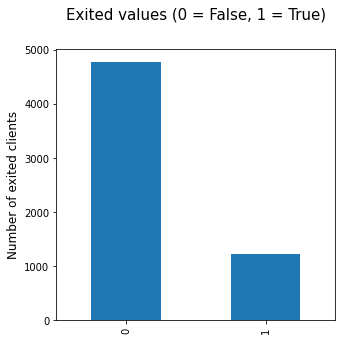

In [11]:
# проверим соотношение классов на тренировочной выборке

xx = target_train.value_counts()
print(xx)
print()
ax = target_train.value_counts().plot(kind='bar', figsize=(5, 5), fontsize=10)
ax.set_title('Exited values (0 = False, 1 = True)', size=15, pad=30)
ax.set_ylabel('Number of exited clients', fontsize=12)

plt.show()

На графике явно виден дисбаланс классов в соотношении почти 4:1

### Обучение модели для логистической регрессии

In [12]:
model_log = LogisticRegression(random_state=12345, solver='liblinear')
model_log.fit(features_train, target_train)
predictions_log = model_log.predict(features_valid)
f1_log = f1_score(target_valid, predictions_log)


probabilities_log = model_log.predict_proba(features_valid)
probabilities_one_log = probabilities_log[:, 1]
auc_roc_log = roc_auc_score(target_valid, probabilities_one_log)

print('Cреднее полноты и точности при дисбалансе:', f1_log)

# выведем AUC_ROC
print()
print("AUC_ROC", auc_roc_log)

Cреднее полноты и точности при дисбалансе: 0.30451127819548873

AUC_ROC 0.77031690347931


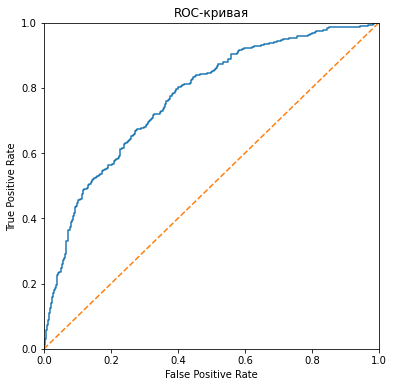

In [13]:
# построим график AUC_ROC для логистической регрессии

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_log)

plt.figure(figsize=(6, 6))

plt.plot(fpr, tpr)

plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

### Обучение модели для решающего дерева

In [14]:
best_model_tree = None
best_result_tree = 0
for depth in range(1, 10):
    model_tree = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_tree.fit(features_train, target_train)
    predictions_tree = model_tree.predict(features_valid)
    f1_result = f1_score(target_valid, predictions_tree)
    
    if f1_result > best_result_tree:
        best_depth = depth
        best_model_tree = model_tree
        best_result_tree = f1_result
        
        probabilities_tree = model_tree.predict_proba(features_valid)
        probabilities_one_tree = probabilities_tree[:, 1]
        auc_roc_tree = roc_auc_score(target_valid, probabilities_one_tree)

        
print("Cреднее полноты и точности лучшей модели при дисбалансе:", best_result_tree, "Глубина:", depth)

# выведем AUC_ROC
print()
print("AUC_ROC", auc_roc_tree)

Cреднее полноты и точности лучшей модели при дисбалансе: 0.5583596214511041 Глубина: 9

AUC_ROC 0.7799335260896587


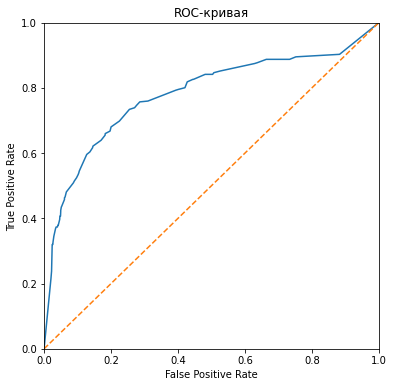

In [15]:
# построим график AUC_ROC для решающего дерева

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_tree)

plt.figure(figsize=(6, 6))

plt.plot(fpr, tpr)

plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

### Обучение модели для случайного леса

In [19]:
best_model_forest = None
best_result_forest = 0
for est in range(1, 85, 10):
    for depth in (range(1, 10)):
        model_forest = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model_forest.fit(features_train, target_train)
        predictions_forest = model_forest.predict(features_valid)
        result_forest = model_forest.score(features_valid, target_valid)
        result_forest = f1_score(target_valid, predictions_forest)

        if result_forest > best_result_forest:
            best_depth = depth
            best_est = est
            best_model_forest = model_forest
            best_result_forest = result_forest
            
            probabilities_forest = model_forest.predict_proba(features_valid)
            probabilities_one_forest = probabilities_forest[:, 1]
            auc_roc_forest = roc_auc_score(target_valid, probabilities_one_forest)
        

print("Cреднее полноты и точности лучшей модели при дисбалансе:", best_result_forest, "Глубина:", depth, 
      "Количество деревьев:", est)

# выведем AUC_ROC
print()
print("AUC_ROC", auc_roc_forest)

Cреднее полноты и точности лучшей модели при дисбалансе: 0.5540983606557377 Глубина: 9 Количество деревьев: 81

AUC_ROC 0.8531406617825881


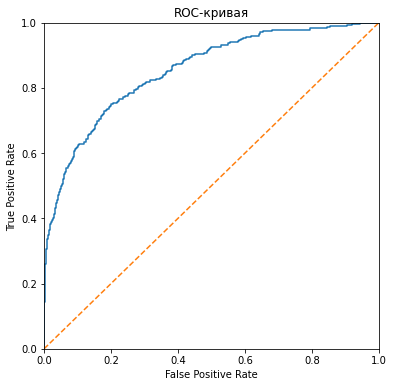

In [20]:
# построим график AUC_ROC для решающего дерева

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_forest)

plt.figure(figsize=(6, 6))

plt.plot(fpr, tpr)

plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

**Вывод**

Классы несбалансированны в соотношении примерно 4:1

После обучения нескольких моделей при дисбалансе получили слудкющие значения метрик:

1. Для логистической регрессии:
- f1-мера - 0.30
- AUC_ROC - 0.77

F1-мера почти в половину меньше AUC_ROC, то есть кривая ошибок у нас относительно хорошая, а прогноз положительных ответов очень низкий.

2. Для решающего дерева:
- f1-мера - 0.56
- AUC_ROC - 0.78

F1-мера намного лучше чем в первой модели, модель обучается и предсказывает ответы неплохо, AUC_ROC такой же как и логистической регрессии.
   
3. Для случайного леса:
- f1-мера - 0.55
- AUC_ROC - 0.85

F1-мера почти не изменилась - модель обучается и предсказывает ответы как и в решающем дереве, значение AUC_ROC выросло и стремится к 1 - доля верно предсказанных объектов увеличилась.


Исходя из полученных значений по трем моделям нам походит решающее дерево и случайный лес. Также ROC-кривые этих моделей выглядят лучше, чем у логистической регрессии.
Можно поробовать улучшить обучающую выборку увеличив ее или уменьшив, также учтем дисбаланс.

## Борьба с дисбалансом

In [21]:
# напишем функцию для увеличения выборки

def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [22]:
# напишем функцию для уменьшения выборки

def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

### Решающее дерево

In [23]:
# проверим как влияет параметр class_weight на показатели классификации

best_model_tree_balanced = None
best_result_tree_balanced = 0
for depth in range(1, 10):
    model_tree_balanced = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced')
    model_tree_balanced.fit(features_train, target_train)
    predictions_tree_balanced = model_tree_balanced.predict(features_valid)
    f1_result_balanced = f1_score(target_valid, predictions_tree_balanced)
    
    if f1_result_balanced > best_result_tree_balanced:
        best_depth = depth
        best_model_tree_balanced = model_tree_balanced
        best_result_tree_balanced = f1_result_balanced
        
        probabilities_tree_balanced = model_tree_balanced.predict_proba(features_valid)
        probabilities_one_tree_balanced = probabilities_tree_balanced[:, 1]
        auc_roc_tree_balanced = roc_auc_score(target_valid, probabilities_one_tree_balanced)

        
print("Cреднее полноты и точности лучшей модели при дисбалансе:", best_result_tree_balanced, "Глубина:", best_depth)

# выведем AUC_ROC
print()
print("AUC_ROC", auc_roc_tree_balanced)

Cреднее полноты и точности лучшей модели при дисбалансе: 0.5587044534412956 Глубина: 6

AUC_ROC 0.8090671240258203


С учетом дисбаланса f1-мера не изменилась, AUC_ROC - увеличилось.

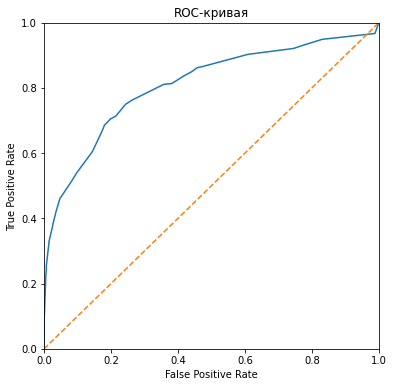

In [34]:
# построим график AUC_ROC для решающего дерева

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_tree_balanced)

plt.figure(figsize=(6, 6))

plt.plot(fpr, tpr)

plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

In [24]:
# применим функцию для увеличения выборки

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

best_model_tree_upsampled = None
best_result_tree_upsampled = 0
for depth in range(1, 10):
    model_tree_upsampled = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_tree_upsampled.fit(features_upsampled, target_upsampled)
    predictions_tree_upsampled = model_tree_upsampled.predict(features_valid)
    f1_result_upsampled = f1_score(target_valid, predictions_tree_upsampled)
    
    if f1_result_upsampled > best_result_tree_upsampled:
        best_depth = depth
        best_model_tree_upsampled = model_tree_upsampled
        best_result_tree_upsampled = f1_result_upsampled
        
        probabilities_tree_upsampled = model_tree_upsampled.predict_proba(features_valid)
        probabilities_one_tree_upsampled = probabilities_tree_upsampled[:, 1]
        auc_roc_tree_upsampled = roc_auc_score(target_valid, probabilities_one_tree_upsampled)

        
print("Cреднее полноты и точности лучшей модели:", best_result_tree_upsampled, "Глубина:", best_depth)

# выведем AUC_ROC
print()
print("AUC_ROC", auc_roc_tree_upsampled)

Cреднее полноты и точности лучшей модели: 0.5587044534412956 Глубина: 6

AUC_ROC 0.809054407830633


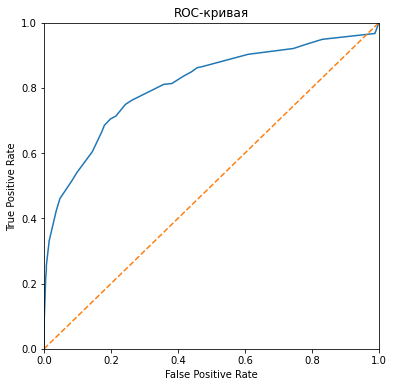

In [25]:
# построим график AUC_ROC для решающего дерева

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_tree_upsampled)

plt.figure(figsize=(6, 6))

plt.plot(fpr, tpr)

plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

In [26]:
# применим функцию для уменьшения выборки

features_downsampled, target_downsampled = downsample(features_train, target_train, .25)

best_model_tree_downsampled = None
best_result_tree_downsampled = 0
for depth in range(1, 10):
    model_tree_downsampled = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_tree_downsampled.fit(features_downsampled, target_downsampled)
    predictions_tree_downsampled = model_tree_downsampled.predict(features_valid)
    f1_result_downsampled = f1_score(target_valid, predictions_tree_downsampled)
    
    if f1_result_downsampled > best_result_tree_downsampled:
        best_depth = depth
        best_model_tree_downsampled = model_tree_downsampled
        best_result_tree_downsampled = f1_result_downsampled
        
        probabilities_tree_downsampled = model_tree_downsampled.predict_proba(features_valid)
        probabilities_one_tree_downsampled = probabilities_tree_downsampled[:, 1]
        auc_roc_tree_downsampled = roc_auc_score(target_valid, probabilities_one_tree_downsampled)

print("Cреднее полноты и точности лучшей модели:", best_result_tree_downsampled, "Глубина:", best_depth)

# выведем AUC_ROC
print()
print("AUC_ROC", auc_roc_tree_downsampled)


Cреднее полноты и точности лучшей модели: 0.5493482309124766 Глубина: 7

AUC_ROC 0.8143546769371137


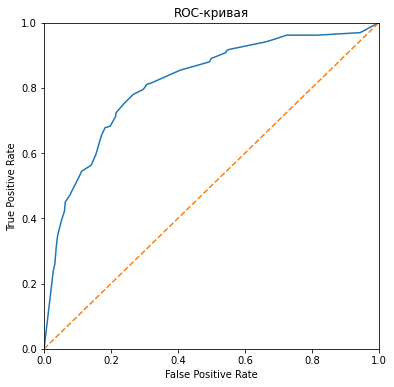

In [27]:
# построим график AUC_ROC для решающего дерева

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_tree_downsampled)

plt.figure(figsize=(6, 6))

plt.plot(fpr, tpr)

plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

**Сбалансировав вес классов для решающего дерева получили f1-меру равной 0,56 и AUC_ROC - 0,81. При увеличении выборки значения f1-меры - 0,56 и AUC_ROC - 0,81. А при уменьшении стали немного меньше, f1-мера - 0,55 и AUC_ROC - 0,81.**

### Случайный лес

In [28]:
# проверим как влияет параметр class_weight на показатели классификации

best_model_forest_balanced = None
best_result_forest_balanced = 0
for est in range(1, 100, 16):
    for depth in (range(1, 16)):
        model_forest_balanced  = RandomForestClassifier(random_state=12345, n_estimators=est,
                                                    max_depth=depth, class_weight='balanced')
        model_forest_balanced.fit(features_train, target_train)
        predictions_forest_balanced = model_forest_balanced.predict(features_valid)
        f1_result_forest_balanced = f1_score(target_valid, predictions_forest_balanced)
        
        if f1_result_forest_balanced > best_result_forest_balanced:
            best_depth = depth
            best_est = est
            best_model_forest_balanced = model_forest_balanced
            best_result_forest_balanced = f1_result_forest_balanced
            
            probabilities_forest_balanced = model_forest_balanced.predict_proba(features_valid)
            probabilities_one_forest_balanced = probabilities_forest_balanced[:, 1]
            auc_roc_forest_balanced = roc_auc_score(target_valid, probabilities_one_forest_balanced)


print("Cреднее полноты и точности лучшей модели:", best_result_forest_balanced, "Глубина:", best_depth, 
      "Количество деревьев:", best_est)

# выведем AUC_ROC
print()
print("AUC_ROC", auc_roc_forest_balanced)


Cреднее полноты и точности лучшей модели: 0.5956873315363881 Глубина: 11 Количество деревьев: 49

AUC_ROC 0.8507086894530287


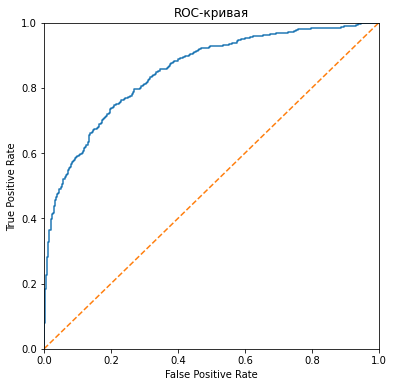

In [29]:
# построим график AUC_ROC для решающего дерева

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_forest_balanced)

plt.figure(figsize=(6, 6))

plt.plot(fpr, tpr)

plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

In [30]:
# применим функцию для увеличения выборки

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

best_model_forest_upsampled = None
best_result_forest_upsampled = 0
for est in range(1, 100, 16):
    for depth in (range(1, 16)):
        model_forest_upsampled  = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        
        model_forest_upsampled.fit(features_upsampled, target_upsampled)
        predictions_forest_upsampled = model_forest_upsampled.predict(features_valid)
        f1_result_forest_upsampled = f1_score(target_valid, predictions_forest_upsampled)
        
        if f1_result_forest_upsampled > best_result_forest_upsampled:
            best_depth = depth
            best_est = est
            best_model_forest_upsampled = model_forest_upsampled
            best_result_forest_upsampled = f1_result_forest_upsampled
            
            probabilities_forest_upsampled = model_forest_upsampled.predict_proba(features_valid)
            probabilities_one_forest_upsampled= probabilities_forest_upsampled[:, 1]
            auc_roc_forest_upsampled = roc_auc_score(target_valid, probabilities_one_forest_upsampled)


print("Cреднее полноты и точности лучшей модели:", best_result_forest_upsampled, "Глубина:", best_depth, 
      "Количество деревьев:", best_est)

# выведем AUC_ROC
print()
print("AUC_ROC", auc_roc_forest_upsampled)


Cреднее полноты и точности лучшей модели: 0.6051282051282051 Глубина: 14 Количество деревьев: 97

AUC_ROC 0.8482337999647125


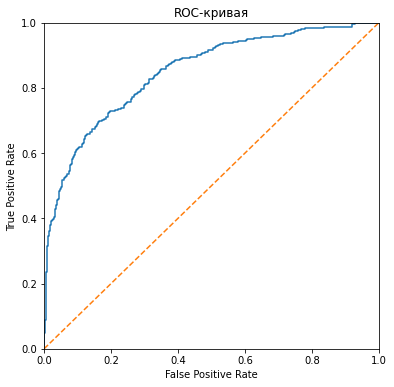

In [31]:
# построим график AUC_ROC для решающего дерева

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_forest_upsampled)

plt.figure(figsize=(6, 6))

plt.plot(fpr, tpr)

plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

In [32]:
# применим функцию для уменьшения выборки

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

best_model_forest_downsampled = None
best_result_forest_downsampled = 0
for est in range(1, 100, 16):
    for depth in (range(1, 16)):
        model_forest_downsampled  = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        
        model_forest_downsampled.fit(features_downsampled, target_downsampled)
        predictions_forest_downsampled = model_forest_downsampled.predict(features_valid)
        f1_result_forest_downsampled = f1_score(target_valid, predictions_forest_downsampled)
        
        if f1_result_forest_downsampled > best_result_forest_downsampled:
            best_depth = depth
            best_est = est
            best_model_forest_downsampled = model_forest_downsampled
            best_result_forest_downsampled = f1_result_forest_downsampled
            
            probabilities_forest_downsampled = model_forest_downsampled.predict_proba(features_valid)
            probabilities_one_forest_downsampled= probabilities_forest_downsampled[:, 1]
            auc_roc_forest_downsampled = roc_auc_score(target_valid, probabilities_one_forest_downsampled)


print("Cреднее полноты и точности лучшей модели:", best_result_forest_downsampled, "Глубина:", best_depth, 
      "Количество деревьев:", best_est)

# выведем AUC_ROC
print()
print("AUC_ROC", auc_roc_forest_downsampled)


Cреднее полноты и точности лучшей модели: 0.5703200775945684 Глубина: 10 Количество деревьев: 81

AUC_ROC 0.8483959314533499


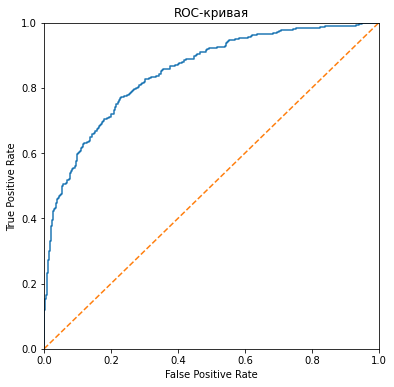

In [33]:
# построим график AUC_ROC для решающего дерева

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_forest_downsampled)

plt.figure(figsize=(6, 6))

plt.plot(fpr, tpr)

plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

**Сбалансировав вес классов для случайного леса получили f1-меру равной 0,59 и AUC_ROC - 0,85 (показатели выше, чем у решающего дерева). При увеличении выборки значения f1-меры - 0,60 и AUC_ROC - 0,85. При уменьшении стали меньше, f1-мера - 0,57 и AUC_ROC - 0,85.**

**Вывод**

На этапе борьбы с дисбалансом получили следующие значения метрик:

F1-мера почти не изменилась - модель обучается и предсказывает ответы как и в решающем дереве, значение AUC_ROC выросло и стремится к 1 - доля верно предсказанных объектов увеличилась.


1. Для решающего дерева:
- при взвешивании классов f1-мера - 0.56, AUC_ROC - 0.81
- при увеличении положительных показателей выборки (1) f1-мера - 0.56, AUC_ROC - 0.81
- при уменьшении отрицательных показателей выборки (0) f1-мера - 0.55, AUC_ROC - 0.81

В каждом пункте значения почти одинаковые. F1-мера показывает, что модель обучается и предсказывает ответы, AUC_ROC дает долю верно предсказанных ответов и она увеличилась после применения нескольких методов борьбы с дисбалансом.

   
2. Для случайного леса:
- при взвешивании классов f1-мера - 0.59, AUC_ROC - 0.85
- при увеличении положительных показателей выборки (1) f1-мера - 0.60, AUC_ROC - 0.85
- при уменьшении отрицательных показателей выборки (0) f1-мера - 0.57, AUC_ROC - 0.85

Здесь значения различаются. Лучшие показатели получились при увеличении выборки и учете дисбаланса. F1-мера показывает, что модель обучается и предсказывает ответы довольно хорошо, AUC_ROC не меняется - доля предсказанных ответов все еще высокая.

Для каждой модели построили графики AUC_ROC. Удовлетворяющие кривые получились у модели "Случайный лес". Согласно полученным значениям f1-меры, нам подходит модель случайного леса с учетом дисбаланса или с увеличением выборки.

## Тестирование модели

### Учет дисбаланса

In [36]:
# объединим обучающую и валидационную выборки
features_total_train = pd.concat([features_train, features_valid])
target_total_train = pd.concat([target_train, target_valid])

# проверим модель с лучшими показателями на тестовой выборке

model_forest_test = RandomForestClassifier(random_state=12345, n_estimators=49, 
                                              max_depth=11, class_weight='balanced')
model_forest_test.fit(features_total_train, target_total_train)
predictions_forest_test = model_forest_test.predict(features_test)
f1_forest_test = f1_score(target_test, predictions_forest_test)

print("Cреднее полноты и точности:", f1_forest_test)
print()

# выведем AUC_ROC

probabilities_forest_test = model_forest_test.predict_proba(features_test)
probabilities_one_forest_test = probabilities_forest_test[:, 1]
auc_roc_forest_test = roc_auc_score(target_test, probabilities_one_forest_test)

print("AUC_ROC", auc_roc_forest_test)


Cреднее полноты и точности: 0.6347305389221557

AUC_ROC 0.8635634112534262


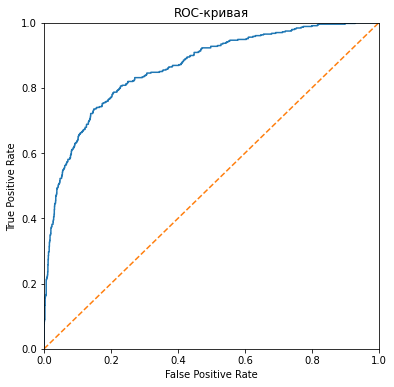

In [37]:
# построим график

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_forest_test)

plt.figure(figsize=(6, 6))

plt.plot(fpr, tpr)

plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

### Увеличение выборки

In [38]:
features_upsampled, target_upsampled = upsample(features_total_train, target_total_train, 4)


model_new_test = RandomForestClassifier(random_state=12345, n_estimators=97, max_depth=14)
model_new_test.fit(features_upsampled, target_upsampled)
predictions_new_test = model_new_test.predict(features_test)
f1_new_test = f1_score(target_test, predictions_new_test)

print("Cреднее полноты и точности:", f1_new_test)
print()

# выведем AUC_ROC

probabilities_new_test = model_new_test.predict_proba(features_test)
probabilities_one_new_test = probabilities_new_test[:, 1]
auc_roc_new_test = roc_auc_score(target_test, probabilities_one_new_test)

print("AUC_ROC", auc_roc_new_test)


Cреднее полноты и точности: 0.6282208588957054

AUC_ROC 0.8611611935009847


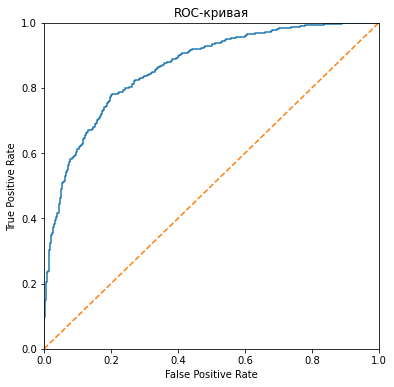

In [36]:
# построим график

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_new_test)

plt.figure(figsize=(6, 6))

plt.plot(fpr, tpr)

plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

**Тестирование модели с увeличением выборки показало значения для f1-меры - 0,65 и AUC_ROC - 0,86.**

**Вывод**

По исследованиям баланса и по итогам борбы с дисбалансом выбрана модель с наилучшим значениями f1-меры и AUC_ROC. 

Модель случайного леса на тестовой выборке вывела значения:
- с учетом дисбаланса - f1 - 0.63, AUC_ROC - 0.86
- при увеличении положительных показателей выборки - f1 - 0.63, AUC_ROC - 0.86

Наша модель хорошо обучилась и при увеличении выборки с нужными гиперпараметрами (количество деревьев - 97, глубина - 14) и с учетом дисбаланса (параметры - количество деревьев - 49, глубина - 11). Это можно увидеть на графиках - ROC-кривая довольно высокая и стремится к единице. Значение f1-меры показывает, что прогноз положительных ответов (класс - 1) удался.